# IRR measurement

## Flags

In [ ]:
output = False

input_version = 6
output_version = 1

## Baseline setup

In [ ]:
import os
import numpy as np
import pandas as pd
from itertools import chain, combinations

In [ ]:
input_dir = "../data-management/output/clean/v{}".format(input_version)
output_dir = "v{}".format(output_version)

# plain text summary of the F-measure for each pair of coders, and averaged
output_irr = "IRR_Fmeasure.txt"

# F-measure and supporting statistics for each document and pair of coders on that document
output_irrda = "IRR_documentwise_pairwise_Fmeasure.csv"
# same as above, but sorted lowest to highest rather than grouped by coder and document names
output_lowest_irrda = "IRR_sorted_documentwise_pairwise_Fmeasure.csv"
# same as above, but excluding Manasvi because she won't be available for modifications
output_active_coders_lowest_irrda = "IRR_sorted_active_documentwise_pairwise_Fmeasure.csv"

# F-measure and supporting statistics for each code and pair of coders
output_codewise_pairwise_irrda = "IRR_codewise_pairwise_Fmeasure.csv"
# F-measure and supporting statistics for each code (I aggregated the coder pairs' a, b, and 
# c values first instead of straight averaging F-values because it was easier with the NaNs)
output_codewise_irrda = "IRR_codewise_Fmeasure.csv"
output_lowest_codewise_irrda = "IRR_sorted_codewise_Fmeasure.csv"

# FIXME make a description file (e.g. what the inputs were)

In [ ]:
if output:
    try:
        os.mkdir(output_dir)
    except FileExistsError:
        print("WARNING: output directory already exists. You might want to increment your version number.")

In [ ]:
# util for displaying dataframes
# the defaults are actually 60 & 20, but that gets annoying
def show(da, rows = 20, cols = 20):
    pd.set_option("display.max_rows", rows)
    pd.set_option("display.max_columns", cols)
    display(da)
    pd.reset_option("max_rows")
    pd.reset_option("max_columns")

In [ ]:
da1 = pd.read_csv(os.path.join(input_dir, "annotations_data.csv"))
dda = pd.read_csv(os.path.join(input_dir, "coders_per_document.csv"))

## Run a fixed-coders analysis on the documents coded by all three annotators

I am following the strategy from [Hripcsak and Rothschild 2005](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1090460/) (1028 Google Scholar citations). They take average pairwise F-statistics. Since we only have 3 pairs, I think we can skip the averaging step. Of note, I can't find any way that they calculate the expected coincidence rate. If possible, I would like to have something in this vein, but even if I follow Krippendorff's approach for that I'm not sure it's compatible with this.

![Hripcsak and Rothschild, Table 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1090460/table/tbl1/?report=objectonly)

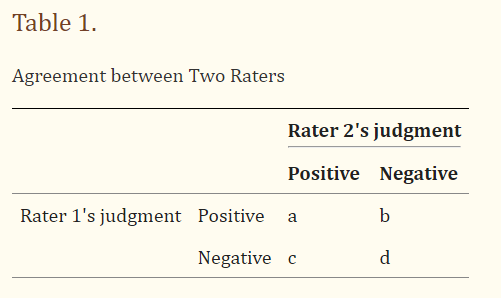

### First draft code (kinda spaghetti-ish)

In [ ]:
def Fmeasure(a, b, c):
    if 2*a + b + c == 0:
        return np.NaN
    return 2*a / (2*a + b + c)

In [ ]:
def Fmeasure(a, b, c):
    return np.where(2*a + b + c == 0, np.NaN, 2*a / (2*a + b + c))

In [ ]:
# return counts for pos/pos, pos/neg, neg/pos (neg/neg is undefined in this strategy)
# I am using relaxed span matches here
# I am assuming that the data1 and data2 dataframes each contain at least one annotation in 
# each document present (i.e. agree exactly on which documents to include) and visit those
# documents in the same order
# I think I am also assuming no exact coder/doc/start/end/label duplicates, but I'm not sure
# if this impacts anything
def agreement(data1, data2, docCol, labelCol, startCol, endCol):
    
    # utility to help handle incrementing pointers
    def entryInfo(data, idx, 
                  docCol = docCol, labelCol = labelCol, 
                  startCol = startCol, endCol = endCol):
        return data.loc[idx, docCol], data.loc[idx, startCol], data.loc[idx, endCol], data.loc[idx, labelCol]
    
    # utility that does most of the work
    def oneway(data1, data2, docCol = docCol, labelCol = labelCol, 
               startCol = startCol, endCol = endCol):
        # edge case
        if data2.shape[0] == 0:
            return 0, data1.shape[0]
        
        # initialize return values
        a, x = 0, 0

        # initialize data2 pointer (to be incremented manually)
        j = 0
        jdoc, jstart, jend, jlab = entryInfo(data2, j) # consider this to be a sort of flattened dictionary order

        # this is a loop over the data1 pointer (incremented automatically)
        for i in range(data1.shape[0]):
            idoc, istart, iend, ilab = entryInfo(data1, i)
            
            # move to the correct document
            while j < data2.shape[0] and jdoc < idoc:
                j += 1
                if j < data2.shape[0]:
                    jdoc, jstart, jend, jlab = entryInfo(data2, j)

            # move to/past the correct time interval
            while j < data2.shape[0] and jdoc == idoc and jend <= istart:
                j += 1
                if j < data2.shape[0]:
                    jdoc, jstart, jend, jlab = entryInfo(data2, j)
            
            k, kdoc, kstart, kend, klab = j, jdoc, jstart, jend, jlab
            matched = False
            
            while k < data2.shape[0] and kdoc == idoc and kstart < iend:
                # this is the pos/pos case
                if ((istart <= kstart < iend or istart < kend <= iend) or 
                    (kstart <= istart < iend <= kend)) and ilab == klab:
                    a += 1
                    matched = True
                
                # increment
                k += 1
                if k < data2.shape[0]:
                    kdoc, kstart, kend, klab = entryInfo(data2, k)
            
            # this is the pos/neg case
            if not matched:
                x += 1
        
        return a, x
        
    # now check both directions
    a1, b = oneway(data1, data2)
    a2, c = oneway(data2, data1)
    assert(a1 == a2)

    return a1, b, c

In [ ]:
# beta = 1 as that's what they did in the paper
def pairwiseF(annDa, docDa, coder1, coder2, coderCol = "annotation.creatingUser", 
              docCol = "document.name", labelCol = "annotation.code", 
              startCol = "quote.startPosition", endCol = "quote.endPosition"):
    
    # identify only the relevant documents for this pairwise comparison
    commonDocs = docDa[docDa[coder1] & docDa[coder2]][docCol]
    
    # now get the relevant annotations from the relevant documents
    posda1 = annDa[annDa[docCol].isin(commonDocs) & 
                   (annDa[coderCol] == coder1)].sort_values(by=[docCol, startCol, endCol]).reset_index(drop=True)
    posda2 = annDa[annDa[docCol].isin(commonDocs) & 
                   (annDa[coderCol] == coder2)].sort_values(by=[docCol, startCol, endCol]).reset_index(drop=True)
    
    a, b, c = agreement(posda1, posda2, docCol = docCol, labelCol = labelCol, 
                        startCol = startCol, endCol = endCol)
    
    if a == 0 and b == 0 and c == 0:
        print("Warning: all zeros")
        #return None
    
    return Fmeasure(a, b, c), a, b, c, posda1.shape[0], posda2.shape[0]

In [ ]:
# try one example
f, a, b, c, n1, n2 = pairwiseF(da1, dda, "Annotator_1", "Annotator_2")
f

In [ ]:
da1["annotation.code"].unique()

In [ ]:
da3 = da1[~da1["annotation.code"].str.startswith("Big picture of an interaction > resolveRequest") & 
          ~da1["annotation.code"].str.startswith("General message attributes > speaker") & 
          #~da1["annotation.code"].str.startswith("Questions > specificity") & 
          ~da1["annotation.code"].str.startswith("Explanations and help > confidenceLevel > phrasedAsQuestion")]

In [ ]:
# do all the pairs
num = 0
denom = 0
outputstr = ""

for i, coder1 in enumerate(indicators[:, 0]):
    for coder2 in indicators[i+1:, 0]:
        outputstr += "{} vs {}\n".format(coder1, coder2)
        f, a, b, c, n1, n2 = pairwiseF(da3, dda, coder1, coder2)
        currstr = "f = {}\na = {}\nb = {}\nc = {}\nn1 = {}\nn2 = {}\n\n".format(f, a, b, c, n1, n2)
        outputstr += currstr
        #print(currstr)
        
        num += f
        denom += 1

outputstr += "Overall average: {}\n".format(num/denom)
print(outputstr)

In [ ]:
if output:
    f = open(os.path.join(output_irr_dir, output_irr), "w")
    f.write(outputstr)
    f.close()

In [ ]:
# DONE filter out success annotations before checking this (also pull new data)
# separately check whether people agree on success/failure (and number of requests)
# might need to account for whether people agree on the number 
# of requests within a chat (remember there could be multiple successes per document)

In [ ]:
# turns out this is theoretically equivalent to the previous thing, according to the primary paper I'm referencing
def positiveSpecificAgreement(data, coder1, coder2):
    pass

### Second draft

In [ ]:
# beta = 1 as that's what they did in the paper
def documentwisePairwiseF(annDa, docDa, coder1, coder2, coderCol = "annotation.creatingUser", 
              docCol = "document.name", labelCol = "annotation.code", 
              startCol = "quote.startPosition", endCol = "quote.endPosition"):

    # identify only the relevant documents for this pairwise comparison
    commonDocs = docDa[docDa[coder1] & docDa[coder2]][docCol] # a Series
    
    arr = np.empty((len(commonDocs), 5), dtype=np.int16)
    aa, bb, cc, nn1, nn2 = 0, 0, 0, 0, 0
    
    # loop over all the relevant documents
    for idx, doc in enumerate(commonDocs):
        # now get the relevant annotations
        posda1 = annDa[(annDa[docCol] == doc) & 
                       (annDa[coderCol] == coder1)].sort_values(by=[docCol, startCol, endCol]).reset_index(drop=True)
        posda2 = annDa[(annDa[docCol] == doc) & 
                       (annDa[coderCol] == coder2)].sort_values(by=[docCol, startCol, endCol]).reset_index(drop=True)

        a, b, c = agreement(posda1, posda2, docCol = docCol, labelCol = labelCol, 
                            startCol = startCol, endCol = endCol)
        
        arr[idx] = [a, b, c, posda1.shape[0], posda2.shape[0]]
        
        aa += a
        bb += b
        cc += c
        nn1 += posda1.shape[0]
        nn2 += posda2.shape[0]
    
    if aa == 0 and bb == 0 and cc == 0:
        print("Warning: all zeros")
        return None
    
    #return 2*aa / (2*aa + bb + cc), aa, bb, cc, nn1, nn2
    tmp = pd.DataFrame(data=commonDocs)
    return pd.concat([tmp, pd.DataFrame(data=arr, columns=["a", "b", "c", "n1", "n2"]).set_index(tmp.index)], 
                     axis="columns")

In [ ]:
# try one example
tmp = documentwisePairwiseF(da3, dda, "Annotator_1", "Annotator_2")
show(tmp, rows=3)

In [ ]:
# do all the pairs
irrda = None

for i, coder1 in enumerate(indicators[:, 0]):
    for coder2 in indicators[i+1:, 0]:
        tmp = documentwisePairwiseF(da3, dda, coder1, coder2)
        
        tmp["coder1"] = coder1
        tmp["coder2"] = coder2
        
        if irrda is None:
            irrda = tmp
        else:
            irrda = pd.concat([irrda, tmp], axis=0) # vertically

irrda = irrda[["document.name", "coder1", "coder2", "a", "b", "c", "n1", "n2"]]
show(irrda, rows=6)

In [ ]:
irrda["F-measure"] = Fmeasure(irrda["a"], irrda["b"], irrda["c"])
show(irrda)

In [ ]:
n = 10
irrda[(irrda["coder1"] != "Manasvi Parikh") & (irrda["coder2"] != "Manasvi Parikh")].nsmallest(n, "F-measure", keep="all")

In [ ]:
# output_irr_dir = os.path.join(output_dir, "IRR")

# output_irr = "IRR_Fmeasure.txt"
# output_irrda = "IRR_documentwise_pairwise_Fmeasure.csv"
# output_lowest_irrda = "IRR_sorted_documentwise_pairwise_Fmeasure.csv"
# output_active_coders_lowest_irrda = "IRR_sorted_active_documentwise_pairwise_Fmeasure.csv"

if output:
    irrda.to_csv(os.path.join(output_irr_dir, output_irrda))
    irrda.sort_values(by="F-measure").to_csv(os.path.join(output_irr_dir, output_lowest_irrda))
    irrda[(irrda["coder1"] != "Manasvi Parikh") & 
          (irrda["coder2"] != "Manasvi Parikh")].sort_values(by="F-measure").to_csv(
        os.path.join(output_irr_dir, output_active_coders_lowest_irrda))

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.figure(figsize=(12, 5), dpi=80)
plt.hist(irrda["F-measure"], bins=20)
plt.xlabel("document-coder-pairs", fontsize=18)
plt.ylabel("F-measure (%)", fontsize=18)
plt.show()

In [ ]:
xx = 2*irrda["a"] + irrda["b"] + irrda["c"]
plt.scatter(xx, 2*irrda["a"])

xmin, xmax = int(np.floor(min(xx))), int(np.ceil(max(xx)))
xx = np.array(range(xmin, xmax+1, (xmax-xmin) // 100))
yy = (num/denom) * xx
plt.plot(xx, yy, color="orange")

plt.xlabel("2a + b + c", fontsize=18)
plt.ylabel("2a", fontsize=18)
plt.show()

In [ ]:
precision = irrda["a"] / (irrda["a"] + irrda["b"])
recall = irrda["a"] / (irrda["a"] + irrda["c"])
plt.scatter(recall, precision)

# scale = 100
# xmin, xmax = int(np.floor(min(recall)*scale)), int(np.ceil(max(recall)*scale))
# xx = np.array(range(xmin, xmax+1, (xmax-xmin) // 10)) / scale
# yy = (num/denom) * xx
# plt.plot(xx, yy, color="orange")

plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.show()

In [ ]:
plt.scatter(irrda["n1"], irrda["n2"])
plt.xlabel("Number of annotations by Coder 1", fontsize=14)
plt.ylabel("Number of annotations by Coder 2", fontsize=14)
plt.show()

## Code-specific IRR

In [ ]:
# do all the pairs
num = 0
denom = 0
outputstr = ""

codes = da3["annotation.code"].unique()
codes.sort()
#codes = codes[:2]

ncoders = indicators.shape[0]
height = (len(codes) * ncoders * (ncoders - 1)) // 2

#arr = np.empty((len(codes) * ncoders**2, 5), dtype=np.int64)
labels = np.empty((height, 3), dtype=object)
arr = np.empty((height, 5), dtype=np.int64)
idx = 0

for code in codes:
    outputstr += "Code: {}\n".format(code)
    for i, coder1 in enumerate(indicators[:, 0]):
        #for coder2 in indicators[:, 0]:
        for coder2 in indicators[i+1:, 0]:
            outputstr += "\t{} vs {}\n".format(coder1, coder2)
            f, a, b, c, n1, n2 = pairwiseF(da3[da3["annotation.code"] == code], dda, coder1, coder2)
            currstr = "\t\tf = {}\n\t\ta = {}\n\t\tb = {}\n\t\tc = {}\n\t\tn1 = {}\n\t\tn2 = {}\n".format(f, a, b, c, n1, n2)
            outputstr += currstr
            #print(currstr)
            labels[idx] = [code, coder1, coder2]
            arr[idx] = [a, b, c, n1, n2]
            idx += 1

            num += f
            denom += 1
    outputstr += "\n"

outputstr += "Overall average: {}\n".format(num/denom)
print(outputstr)

#tmp_code = np.repeat(codes, ncoders**2)
#tmp_coder1 = np.tile(np.repeat(indicators[:, 0], indicators.shape[0]), len(codes))
#tmp_coder2 = np.tile(indicators[:, 0], len(codes) * indicators.shape[0])

#tmp_da = pd.DataFrame({"annotation.code" : tmp_code, "coder1" : tmp_coder1, "coder2" : tmp_coder2})
tmp_da = pd.DataFrame(data=labels, columns=["annotation.code", "coder1", "coder2"])

codewise_pairwise_irrda = pd.concat([tmp_da, 
                                     pd.DataFrame(data=arr, columns=["a", "b", "c", "n1", "n2"]).set_index(tmp_da.index)], 
                                    axis="columns")


In [ ]:
#codewise_pairwise_irrda["f"] = Fmeasure(codewise_pairwise_irrda["a"], codewise_pairwise_irrda["b"], codewise_pairwise_irrda["c"])
codewise_pairwise_irrda["f"] = None
for row in range(codewise_pairwise_irrda.shape[0]):
    codewise_pairwise_irrda.loc[row, "f"] = Fmeasure(codewise_pairwise_irrda.loc[row, "a"], 
                                                     codewise_pairwise_irrda.loc[row, "b"], 
                                                     codewise_pairwise_irrda.loc[row, "c"])
codewise_pairwise_irrda

In [ ]:
# convert from 0-dimensional array values to scalar values (I know, it's stupid)
codewise_pairwise_irrda["f"] = codewise_pairwise_irrda["f"].map(lambda x: x.item())

In [ ]:
codewise_pairwise_irrda.sort_values(by=["f", "annotation.code", "coder1", "coder2"])

In [ ]:
# not relevant since I'm excluding these rows at the computation stage now
#codewise_pairwise_irrda[codewise_pairwise_irrda["coder1"] == codewise_pairwise_irrda["coder2"]]["f"].value_counts()

In [ ]:
#codewise_pairwise_irrda = codewise_pairwise_irrda[codewise_pairwise_irrda["coder1"] != codewise_pairwise_irrda["coder2"]].reset_index(drop=True)
#codewise_pairwise_irrda

In [ ]:
codewise_irrda = codewise_pairwise_irrda[["annotation.code", 
                                          "a", "b", "c", "n1", "n2"]].groupby(by="annotation.code").agg("sum").reset_index()

codewise_irrda["f"] = None
for row in range(codewise_irrda.shape[0]):
    codewise_irrda.loc[row, "f"] = Fmeasure(codewise_irrda.loc[row, "a"], 
                                            codewise_irrda.loc[row, "b"], 
                                            codewise_irrda.loc[row, "c"])

sorted_codewise_irrda = codewise_irrda.sort_values(by=["f"]).reset_index(drop=True)
show(sorted_codewise_irrda, rows=8)

In [ ]:
# debugging the NaN problem

In [ ]:
codewise_pairwise_irrda[codewise_pairwise_irrda["f"].isna()]

In [ ]:
na_codes = codewise_pairwise_irrda[codewise_pairwise_irrda["f"].isna()]["annotation.code"].unique()
na_codes

In [ ]:
# so now we take a straightforward average (like in the paper) but without these two tags
# b, c, n1, and n2 are pretty much meaningless (unless combined, which I don't know how 
# to do off the top of my head and I don't really feel like trying to figure it out atm)
codewise_irrda2 = codewise_pairwise_irrda[
    ~codewise_pairwise_irrda["annotation.code"].isin(na_codes)].groupby(
    by="annotation.code").agg({"a" : "sum", 
                               "b" : "sum", 
                               "c" : "sum", 
                               "n1" : "sum", 
                               "n2" : "sum", 
                               "f" : "mean"}).reset_index()

show(codewise_irrda2.sort_values(by=["f", "annotation.code"]), rows=12)

In [ ]:
pd.set_option("display.max_colwidth", None)
display(codewise_irrda2.sort_values(by=["f", "annotation.code"]))
pd.reset_option("display.max_colwidth")

In [ ]:
# I've now decided that version 2 of the codewise IRR da makes more sense than version 1 so I'm switching

In [ ]:
# output_codewise_pairwise_irrda = "IRR_codewise_pairwise_Fmeasure.csv"
# output_codewise_irrda = "IRR_codewise_Fmeasure.csv"
# output_lowest_codewise_irrda = "IRR_sorted_codewise_Fmeasure.csv"

if output:
    codewise_pairwise_irrda.to_csv(os.path.join(output_irr_dir, output_codewise_pairwise_irrda))
    codewise_irrda.to_csv(os.path.join(output_irr_dir, output_codewise_irrda))
    sorted_codewise_irrda.to_csv(os.path.join(output_irr_dir, output_lowest_codewise_irrda))
    
    codewise_irrda2.to_csv(os.path.join(output_irr_dir, output_codewise_irrda.split(".")[0] + "2.csv"))
    codewise_irrda2.sort_values(by=["f", "annotation.code"]).reset_index(drop=True).to_csv(
        os.path.join(output_irr_dir, output_lowest_codewise_irrda.split(".")[0] + "2.csv"))

## Scraps

In [ ]:
print(da1[da1["annotation.creatingUser"].isin({"Annotator_1", "Annotator_2"})].shape)
da1[(da1["annotation.creatingUser"] == "Annotator_1") | (da1["annotation.creatingUser"] == "Annotator_2")].shape

In [ ]:
len(dda.iloc[0]) == len(dda.columns)

In [ ]:
dda.loc[0, "document.creatingUser"]

In [ ]:
for k in range(dda.shape[0]):
    row = dda.iloc[k]
    show(row)

In [ ]:
np.sort(da1["annotation.code"].unique())

In [ ]:
(3 + 6 + 4 + 2 + (8 * 2 * 2 * 14) + (5 * 2 * 14)) * 2 * 3 * 133

In [ ]:
# test version
testDa = pd.DataFrame(data={"coder"  : ["Alice", "Bob", "Bob",   "Bob"], 
                            "doc"    : ["one",   "one", "one",   "one"], 
                            "label"  : ["x",     "x",   "x",     "x"], 
                            "start"  : [1,       3,     9,       10], 
                            "end"    : [3,       10,    11,      12]})

testDda = pd.DataFrame(data={"doc"   : ["one"], 
                             "Alice" : [True], 
                             "Bob"   : [True]})

pairwiseF(testDa, testDda, "Alice", "Bob", "coder", "doc", "label", "start", "end")

In [ ]:
s = 2639
dl = 73
dh = -28
testda = da1.iloc[s-dl:s+dh].reset_index(drop=True)
testda.shape

In [ ]:
# real test version
documentinfo = list(filter(lambda col : col.startswith("document."), testda.columns))
testdda = testda.groupby(by="document.name", 
                         as_index=False).agg({**{col : [lambda x : x.iloc[0]] for col in documentinfo}, 
                                              **{"annotation.creatingUser" : indicators[:, 1]}})
testdda.columns = np.concatenate((testdda.columns.get_level_values(level=0)[:-len(indicators[:, 0])], # other metadata fields
                                  indicators[:, 0])) # people names
testdda

In [ ]:
"2I1pDSUuKI.txt" < "4RgDwDpNx3.txt"

In [ ]:
pairwiseF(testda, testdda, "Annotator_1", "Annotator_0")

In [ ]:
# linear version
# total 1: 5539
# total 2: 5574

# expected this to add up to the totals and it did
# a1: 134
# a2: 102
# b: 5405
# c: 5472

# this doesn't need to add up to the totals
# a1: 439
# a2: 349
# b: 5150
# c: 5228

# quadratic version
# total 1: 5539
# total 2: 5574
# a1: 52
# a2: 73
# b: 5487
# c: 5501

In [ ]:
# this doesn't work
def codewisePairwiseF(annDa, docDa, coder1, coder2, coderCol = "annotation.creatingUser", 
              docCol = "document.name", labelCol = "annotation.code", 
              startCol = "quote.startPosition", endCol = "quote.endPosition"):

    # identify only the relevant codes for this pairwise comparison
    commonCodes = annDa[(annDa[coderCol] == coder1) | (annDa[coderCol] == coder2)][labelCol].unique() # a Series
    
    arr = np.empty((len(commonCodes), 5), dtype=np.int16)
    aa, bb, cc, nn1, nn2 = 0, 0, 0, 0, 0
    
    # loop over all the relevant documents
    for idx, code in enumerate(commonCodes):
        # now get the relevant annotations
        posda1 = annDa[(annDa[labelCol] == code) & 
                       (annDa[coderCol] == coder1)].sort_values(by=[docCol, startCol, endCol]).reset_index(drop=True)
        posda2 = annDa[(annDa[labelCol] == code) & 
                       (annDa[coderCol] == coder2)].sort_values(by=[docCol, startCol, endCol]).reset_index(drop=True)

        a, b, c = agreement(posda1, posda2, docCol = docCol, labelCol = labelCol, 
                            startCol = startCol, endCol = endCol)
        
        arr[idx] = [a, b, c, posda1.shape[0], posda2.shape[0]]
        
        aa += a
        bb += b
        cc += c
        nn1 += posda1.shape[0]
        nn2 += posda2.shape[0]
    
    if aa == 0 and bb == 0 and cc == 0:
        print("Warning: all zeros")
        return None
    
    #return 2*aa / (2*aa + bb + cc), aa, bb, cc, nn1, nn2
    tmp = pd.DataFrame(data=commonDocs)
    return pd.concat([tmp, pd.DataFrame(data=arr, columns=["a", "b", "c", "n1", "n2"]).set_index(tmp.index)], 
                     axis="columns")